# PINN for RC circuit with physics loss


In [62]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv 
import pandas as pd
import joblib
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from pinn import Net

# Device mps pour mac, cuda sinon et cpu pour les losers
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

sns.set_theme()

In [80]:
# Import des données
df = pd.read_csv("rc_transient.csv")

df_sample = df.sample(n=500000, random_state=42)

X = df_sample[["R", "C", "Time", "Vin"]].values
y = df_sample[["Vout"]].values

# Vanilla Network

In [63]:
# Création du modèle
net = Net(4, 1, loss2=None, epochs=20, batch_size=512, lr=1e-5).to(device)

# Entrainement du modèle
# losses = net.fit(X, y)
# plt.plot(losses)

# Sauvegarde du modèle
# torch.save(net.state_dict(), "vanilla_rc_transient.pt")
# joblib.dump(net.scaler_X, "vanilla_rc_transient_scaler_X.pkl")
# joblib.dump(net.scaler_y, "vanilla_rc_transient_scaler_y.pkl")

# Chargement du modèle suavegardé
net.load_state_dict(torch.load("vanilla_rc_transient.pt"))
net.scaler_X = joblib.load("vanilla_rc_transient_scaler_X.pkl")
net.scaler_y = joblib.load("vanilla_rc_transient_scaler_y.pkl")

(76, 1)
(76,)


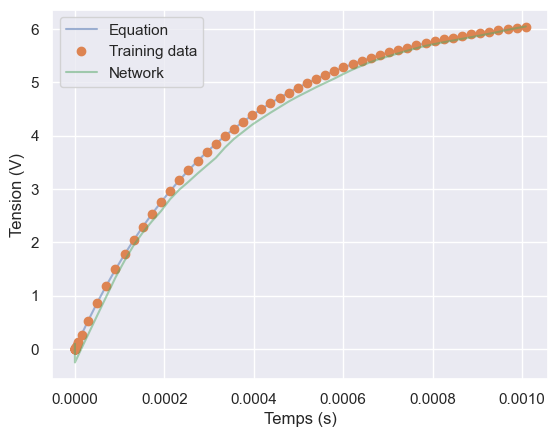

In [64]:
# X_preds = X[30782:30912, :]
# y_preds = y[30782:30912]
X_preds = df[["R", "C", "Time", "Vin"]].values[27222:27298, :]
y_preds = df[["Vout"]].values[27222:27298]

preds = net.predict(X_preds)

equation = X_preds[:, 3] * (1 - np.exp(-X_preds[:, 2]/(X_preds[:, 0]*X_preds[:, 1])))

plt.plot(X_preds[:, 2], equation, alpha=0.5)
plt.plot(X_preds[:, 2], y_preds, 'o')
plt.plot(X_preds[:, 2], preds, alpha=0.5)

plt.legend(labels=['Equation','Training data', 'Network'])
plt.ylabel('Tension (V)')
plt.xlabel('Temps (s)')

print(y_preds.shape)
print(equation.shape)

# PINN

## The differential equation that controls our physics loss 

## ⚙️ Differential Equation of an RC Circuit (Time Domain)

The first-order differential equation for the voltage across a capacitor in an RC circuit is:

$$
Vout(t) + RC \cdot \frac{dVout(t)}{dt} = Vin
$$

Where:
- \( Vout(t) \) is the output voltage (e.g. across the capacitor),
- \( R \) is the resistance (Ω),
- \( C \) is the capacitance (F),
- \( Vin \) is the constant input voltage.

This equation describes the dynamic response of the voltage in the circuit over time.


In [68]:
def rc_transient_loss(model: torch.nn.Module, X):
    # Création de données allant de 3t à 5t
    scaler = model.scaler_X

    X_np = X.detach().cpu().numpy()
    X_np = scaler.inverse_transform(X_np)
    X_futur = None
    for x in X_np:
        x_df = pd.DataFrame([x], columns=["R", "C", "Time", "Vin"])
        x_df = pd.concat([x_df]*8, ignore_index=True)

        time_values = [(3.25 + i*0.25) * x[0] * x[1] for i in range(8)]
        x_df["Time"] = time_values

        if X_futur is None:
            X_futur = x_df.values
        else:
            X_futur = np.vstack([X_futur, x_df.values])

    X_np = np.vstack([X_np, X_futur])
    X = torch.tensor(scaler.transform(X_np), dtype=torch.float32, requires_grad=True).to(device)
    Vout = model(X)

    d_vout = (torch.autograd.grad(Vout, X, grad_outputs=torch.ones_like(Vout), create_graph=True)[0])[:,2]

    R = X[:, 0]
    C = X[:, 1]
    Vin = X[:, 3]

    erreur = Vout[:,0] + R*C*d_vout - Vin

    return torch.mean(erreur**2)

In [82]:
# Création du modèle
net_pinn = Net(4, 1, loss2=rc_transient_loss, loss2_weight=1, epochs=20, batch_size=2048, lr=1e-5).to(device)

# Entrainement du modèle
losses_pinn = net_pinn.fit(X, y)
plt.plot(losses_pinn)

# Sauvegarde du modèle
# torch.save(net_pinn.state_dict(), "pinn_rc_transient.pt")
# joblib.dump(net_pinn.scaler_X, "pinn_rc_transient_scaler_X.pkl")
# joblib.dump(net_pinn.scaler_y, "pinn_rc_transient_scaler_y.pkl")

# Chargement du modèle suavegardé
# net.load_state_dict(torch.load("pinn_rc_transient.pt"))
# net.scaler_X = joblib.load("pinn_rc_transient_scaler_X.pkl")
# net.scaler_y = joblib.load("pinn_rc_transient_scaler_y.pkl")

Epoch 0/20, loss: 1.9648


KeyboardInterrupt: 

(76, 1)
(76,)


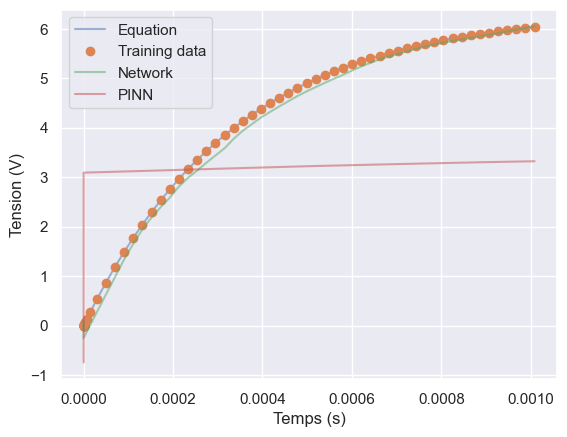

In [78]:
# X_preds = X[30782:30912, :]
# y_preds = y[30782:30912]
X_preds = df[["R", "C", "Time", "Vin"]].values[27222:27298, :]
y_preds = df[["Vout"]].values[27222:27298]

preds_net = net.predict(X_preds)
preds_pinn = net_pinn.predict(X_preds)

equation = X_preds[:, 3] * (1 - np.exp(-X_preds[:, 2]/(X_preds[:, 0]*X_preds[:, 1])))

plt.plot(X_preds[:, 2], equation, alpha=0.5)
plt.plot(X_preds[:, 2], y_preds, 'o')
plt.plot(X_preds[:, 2], preds, alpha=0.5)
plt.plot(X_preds[:, 2], preds_pinn, alpha=0.5)

plt.legend(labels=['Equation','Training data', 'Network', 'PINN'])
plt.ylabel('Tension (V)')
plt.xlabel('Temps (s)')

print(y_preds.shape)
print(equation.shape)

1e-05


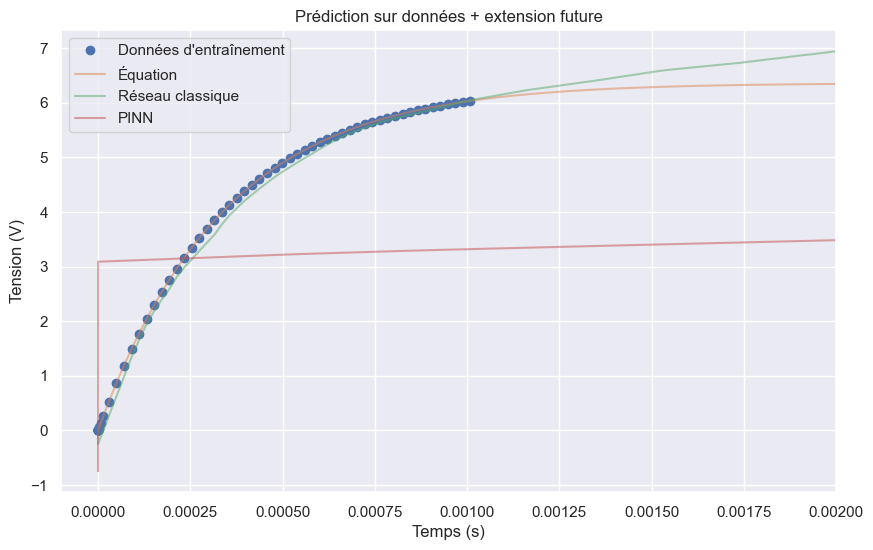

In [79]:
# Données existantes (extraites de ton df)
X_train = df[["R", "C", "Time", "Vin"]].values[27222:27298, :]
y_train = df[["Vout"]].values[27222:27298]

# Étendre dans le futur à partir du dernier temps connu
last_time = X_train[-1, 2]
step = 0.00001
print(step)
t_future = np.arange(X_train[:, 2].max() + step, X_train[:, 2].max() + 100*step, step)  # 100 pas de temps dans le futur

# Répéter les dernières valeurs R, C, Vin sur la plage future
rcv_last = X_train[-1, [0, 1, 3]]
rcv_repeated = np.tile(rcv_last, (len(t_future), 1))

# Construire DataFrame futur
df_future = pd.DataFrame(rcv_repeated, columns=["R", "C", "Vin"])
df_future["Time"] = t_future
df_future = df_future[["R", "C", "Time", "Vin"]]

X_future = df_future.values

# Concaténer les données d'entraînement et futures
X_total = np.vstack([X_train, X_future])

# Faire les prédictions sur tout
preds_net_total = net.predict(X_total)
preds_pinn_total = net_pinn.predict(X_total)

# Calculer la solution analytique
equation_total = X_total[:, 3] * (1 - np.exp(-X_total[:, 2] / (X_total[:, 0] * X_total[:, 1])))

# Tracer
plt.figure(figsize=(10, 6))

# Points uniquement sur données d'entraînement
plt.plot(X_train[:, 2], y_train, 'o', label="Données d'entraînement")

# Courbes sur la totalité (train + futur)
plt.plot(X_total[:, 2], equation_total, label="Équation", alpha=0.5)
plt.plot(X_total[:, 2], preds_net_total, label="Réseau classique", alpha=0.5)
plt.plot(X_total[:, 2], preds_pinn_total, label="PINN", alpha=0.5)

plt.title("Prédiction sur données + extension future")
plt.xlabel("Temps (s)")
plt.ylabel("Tension (V)")
plt.legend()
plt.grid(True)
plt.xlim(-0.0001, 0.002)
plt.show()